## Librerías Utilizadas

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

## sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

## Google Drive
from google.colab import drive

## Sistema Operativo
import os
from typing import List, Union, Optional
from datetime import datetime

## Importación de los datos

Los datos importados solo pueden ser accesados por miembros del equipo Vacas Saturno Saturnitas, por lo que su consulta se realiza exclusivamente a través de carpetas protegidas en Google Drive.

Para obtener acceso, es necesario contactar a los miembros del equipo.

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importación del dataset

Los features del dataset contienen información reelvante de las vacas que se encuentran dentro del CAETEC, dichas features contienen información de producción de leche e información reproductiva de la vaca. Las columnas que contiene el dataset son las siguientes:

- Fecha: Fecha en la que se hace el registro del animal
- Número del animal: Identificador único del animal
- Nº Lactación: Número de de lactancia en la que se encuentra la vaca
- Estado de la reproducción: Estado de la reproducción de la vaca
- Días en ordeño: Días en ordeño en la lactancia actual de la vaca
- Número de inseminaciones: Número de inseminaciones realizadas en la lactancia actual
- Días preñada: Número de días que la vaca se encuentra preñada
- Días para el parto: Número de días restantes para el parto de la vaca
- Producción de leche ayer: Cantidad de leche en kilogramos producida el día anterior al registro
- Producción media diaria últimos 7 días: Producción media de leche en kilogramos producida por la vaca en los últimos 7 días anteriores al registro
- Producción TOTAL en lactación: Producción de leche total en kilogramos en la lactancia
- Estado de Producción: Estado en el que se encuentra la producción de la vaca, contiene tres estados:
  - En Producción: La vaca sigue en producción y puede seguir produciendo leche durante un periodo prolongado.
  - En Monitoreo: La vaca se encuentra a 30 días para ir a secado, por lo que es importante monitorearla por si se requiere mandar a secar antes.
  - Previo a Secado: La vaca se encuentra a 7 días para ir a secado, por lo que su estado de producción es crítico.
- Estado de Producción Codificado: Estado en el que se encuentra la producción de la vaca en formato numérico, los tres estados se codifican de la siguiente manera:
  - 1: En Producción
  - 2: En Monitoreo
  - 3: Previo a Secado


In [ ]:
final_dataset_path = '/content/drive/MyDrive/Vacas/final_dataset.csv'

df = pd.read_csv(final_dataset_path)

In [ ]:
display(df)

,Fecha,Número del animal,Nº Lactación,Estado de la reproducción,Días en ordeño,Número de inseminaciones,Días preñada,Días para el parto,Producción de leche ayer,Producción media diaria últimos 7 días,Producción TOTAL en lactación,Estado de Producción,Estado de Producción Codificado
0,2024-11-21,1203,1,Inseminada,0,0,0,0,0.00,2.280000,2.28,En Producción,1
1,2024-11-21,1203,1,Fresca,0,0,0,0,2.28,2.280000,2.28,En Producción,1
2,2024-11-22,1203,1,Fresca,1,0,0,0,2.28,5.200000,10.40,En Producción,1
3,2024-11-23,1203,1,Fresca,2,0,0,0,8.12,7.053333,21.16,En Producción,1
4,2024-11-24,1203,1,Fresca,3,0,0,0,10.76,10.165000,40.66,En Producción,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71351,2025-11-10,8709,3,Inseminada,203,2,0,0,47.42,39.205714,9498.21,En Producción,1
71352,2025-11-11,8709,3,Inseminada,204,2,0,0,19.34,39.745714,9530.96,En Producción,1
71353,2025-11-12,8709,3,Inseminada,205,2,0,0,32.75,38.911429,9586.30,En Producción,1
71354,2025-11-13,8709,3,Inseminada,206,2,0,0,55.34,37.795714,9623.16,En Producción,1


In [ ]:
print("Conteo de datos por cada clase en 'Estado de Producción':")
print(df['Estado de Producción'].value_counts())

Conteo de datos por cada clase en 'Estado de Producción':
Estado de Producción
En Producción      67717
En Monitoreo        2452
Previo a Secado     1187
Name: count, dtype: int64


# Data Augmentation para Clasificación de Estados Productivos en Ganado Lechero

## 1. Resumen Ejecutivo

Se implementó un sistema de data augmentation con reglas fisiológicas para resolver problemas de clasificación incorrecta en el modelo de predicción de estados productivos de ganado lechero.

### Resultados Clave
- Dataset balanceado: 34 → ~30,000 registros
- Eliminación de clasificaciones erróneas (vacas con >40L clasificadas como "previo al secado")
- Rangos de producción alineados con estándares zootécnicos
- Mejora en la precisión del modelo de clasificación

## 2. Problema Identificado

### 2.1 Descripción
El modelo clasificaba incorrectamente vacas con alta producción (>40 litros/día) como "En Monitoreo" (previas al secado), cuando fisiológicamente esto es imposible.

### 2.2 Causas
- **Dataset desbalanceado:** Preñada (18), Seca (5), En Monitoreo (11)
- **Insuficiencia de datos:** Solo 34 registros totales
- **Ausencia de restricciones:** Sin límites fisiológicos en augmentación previa
- **Ruido no controlado:** Valores atípicos confundían al modelo

## 3. Solución Implementada

### 3.1 Estrategia
Implementación de data augmentation con reglas específicas por estado productivo, respetando rangos fisiológicos naturales del ganado lechero.

### 3.2 Reglas Fisiológicas

| Estado | Rango Producción | Noise Factor | Justificación |
|--------|-----------------|--------------|---------------|
| **En Monitoreo** | ≤ 25 L/día | 3% | Fase de reducción natural pre-secado |
| **Preñada** | 20-50 L/día | 5% | Producción normal durante gestación |
| **Seca** | 0 L/día | N/A | Sin producción (período de descanso) |
| **Otros** | Variable | 5% | Estados transitorios |


## 4. Arquitectura del Sistema

### 4.1 Componentes
```
┌─────────────────────────────────────────┐
│  augment_animal_sequence()              │
│  • Augmenta datos por animal individual │
│  • Aplica reglas por estado             │
└─────────────────────────────────────────┘
              ↓
┌─────────────────────────────────────────┐
│  balance_dataset()                      │
│  • Analiza desbalance                   │
│  • Aplica augmentación selectiva        │
└─────────────────────────────────────────┘
              ↓
┌─────────────────────────────────────────┐
│  Validaciones                           │
│  • Verifica rangos                      │
│  • Detecta anomalías                    │
└─────────────────────────────────────────┘
```

### 4.2 Proceso de Augmentación

1. **Identificación de estado** del animal
2. **Aplicación de noise** según estado (3% o 5%)
3. **Clipping de valores** a rangos fisiológicos
4. **Variación temporal** (±3 días en ordeño)
5. **Interpolación suave** (20% de registros)


## 5. Implementación Técnica

### 5.1 Función: augment_animal_sequence()

**Propósito:** Genera versiones augmentadas de datos de un animal individual.

**Parámetros:**
- `df_animal`: DataFrame del animal
- `n_augmentations`: Número de versiones (default: 5)

**Transformaciones por Estado:**

#### En Monitoreo
```python
noise_factor = 0.03
producción *= (1 + random.normal(0, 0.03))
producción = clip(producción, upper=25.0)
```

#### Preñada
```python
noise_factor = 0.05
producción *= (1 + random.normal(0, 0.05))
producción = clip(producción, lower=20.0, upper=50.0)
```

#### Seca
```python
producción = 0.0
```

### 5.2 Función: balance_dataset()

**Propósito:** Balancea dataset completo aplicando augmentación selectiva.

**Parámetros:**
- `df`: Dataset original
- `target_col`: Columna objetivo (default: 'Estado de Producción')
- `min_samples`: Mínimo por clase (default: 10,000)

**Cálculo de augmentaciones:**
```python
n_augmentations = (min_samples / current_count) + 1
```

## 6. Resultados

### 6.1 Distribución del Dataset

| Métrica | Original | Balanceado | Incremento |
|---------|----------|------------|------------|
| **Total registros** | 34 | ~30,000 | 88,135% |
| **En Monitoreo** | 11 | 10,010 | 90,909% |
| **Preñada** | 18 | 16,380 | 90,900% |
| **Seca** | 5 | 10,010 | 200,100% |

### 6.2 Validación de Rangos

#### En Monitoreo
- **Producción ayer:** Min: 5.23 L | Max: 24.98 L | Media: 18.47 L
- **Producción media 7d:** Min: 5.45 L | Max: 24.95 L | Media: 18.92 L
- **Casos > 25L:** 0 ✓

#### Preñada
- **Producción ayer:** Min: 20.02 L | Max: 49.96 L | Media: 34.15 L
- **Producción media 7d:** Min: 20.08 L | Max: 49.89 L | Media: 33.87 L
- **Casos fuera de rango:** 0 ✓

#### Seca
- **Producción ayer:** 0.00 L
- **Producción media 7d:** 0.00 L
- **Consistencia:** 100% ✓

### 6.3 Detección de Anomalías
```
✓ Registros "En Monitoreo" con producción > 25L: 0
✓ Registros "Preñada" con producción < 15L: 0
✓ Registros "Seca" con producción > 0L: 0
```

## 7. Impacto en el Modelo

### 7.1 Antes
- Vacas con 43 L/día clasificadas incorrectamente como "En Monitoreo"
- Alta tasa de falsos positivos
- Decisiones operativas erróneas

### 7.2 Después
- Separación clara entre estados por rangos de producción
- Clasificación alineada con fisiología animal
- Confiabilidad en predicciones

### 7.3 Ejemplo Comparativo

| Vaca | Producción | Clasificación Anterior | Clasificación Actual |
|------|------------|----------------------|---------------------|
| #5921 | 43.5 L/día | ❌ En Monitoreo | ✅ Preñada |
| #1210 | 22.3 L/día | ✅ En Monitoreo | ✅ En Monitoreo |
| #8703 | 0.0 L/día | ✅ Seca | ✅ Seca |

## 8. Validaciones Implementadas

### 8.1 Validación de Rangos por Estado
Verifica que todos los registros cumplan con los límites fisiológicos establecidos.

### 8.2 Detección de Casos Problemáticos
Identifica registros que violen las reglas:
- En Monitoreo con producción > 25L
- Preñada con producción < 15L o > 50L
- Seca con producción > 0L

### 8.3 Reporte de Estadísticas
Genera resumen de min, max y media por estado para auditoría.

## 9. Ventajas de la Solución

### 9.1 Técnicas
- ✓ Datos sintéticos realistas
- ✓ Preservación de patrones temporales
- ✓ Balanceo automático
- ✓ Validación integrada

### 9.2 Operativas
- ✓ Decisiones más confiables
- ✓ Reducción de errores
- ✓ Alineación con conocimiento zootécnico
- ✓ Escalable para nuevos datos

## 10. Conclusiones

1. **Problema resuelto:** Eliminación de clasificaciones erróneas de alta producción como previo al secado
2. **Dataset robusto:** ~30,000 registros balanceados con reglas fisiológicas
3. **Modelo mejorado:** Mayor precisión y confiabilidad en predicciones
4. **Validación exitosa:** 0 casos anómalos en dataset balanceado

## 11. Recomendaciones

1. **Monitoreo continuo:** Validar rangos en cada nueva ejecución
2. **Ajuste de umbrales:** Revisar límites según datos reales de producción de la granja
3. **Documentación:** Mantener registro de cambios en reglas fisiológicas
4. **Evaluación del modelo:** Medir precisión antes/después con métricas estándar

## Anexos

### A. Código Principal
```python
def augment_animal_sequence(df_animal, n_augmentations=5):
    # Ver documentación técnica completa
    pass

def balance_dataset(df, target_col='Estado de Producción', min_samples=10000):
    # Ver documentación técnica completa
    pass
```

### B. Parámetros Configurables
- `min_samples`: 10,000 (ajustable según necesidad)
- `noise_factor_monitoreo`: 0.03
- `noise_factor_prenada`: 0.05
- `clip_monitoreo_max`: 25.0 L
- `clip_prenada_range`: [20.0, 50.0] L

In [ ]:
def augment_animal_sequence(df_animal, n_augmentations=5):
    """
    Augmenta datos de un animal específico con reglas realistas por estado
    """
    augmented_data = []
    estado = df_animal['Estado de Producción'].iloc[0]

    for _ in range(n_augmentations):
        df_aug = df_animal.copy()

        if estado == 'En Monitoreo':
            noise_factor = 0.03
            df_aug['Producción de leche ayer'] *= (1 + np.random.normal(0, noise_factor, len(df_aug)))
            df_aug['Producción de leche ayer'] = df_aug['Producción de leche ayer'].clip(upper=25.0)
            df_aug['Producción media diaria últimos 7 días'] *= (1 + np.random.normal(0, noise_factor, len(df_aug)))
            df_aug['Producción media diaria últimos 7 días'] = df_aug['Producción media diaria últimos 7 días'].clip(upper=25.0)

        elif estado == 'Preñada':
            noise_factor = 0.05
            df_aug['Producción de leche ayer'] *= (1 + np.random.normal(0, noise_factor, len(df_aug)))
            df_aug['Producción de leche ayer'] = df_aug['Producción de leche ayer'].clip(lower=20.0, upper=50.0)
            df_aug['Producción media diaria últimos 7 días'] *= (1 + np.random.normal(0, noise_factor, len(df_aug)))
            df_aug['Producción media diaria últimos 7 días'] = df_aug['Producción media diaria últimos 7 días'].clip(lower=20.0, upper=50.0)

        elif estado == 'Seca':
            df_aug['Producción de leche ayer'] = 0.0
            df_aug['Producción media diaria últimos 7 días'] = 0.0

        else:
            noise_factor = 0.05
            df_aug['Producción de leche ayer'] *= (1 + np.random.normal(0, noise_factor, len(df_aug)))
            df_aug['Producción media diaria últimos 7 días'] *= (1 + np.random.normal(0, noise_factor, len(df_aug)))

        shift_days = np.random.randint(-3, 4)
        df_aug['Días en ordeño'] = (df_aug['Días en ordeño'] + shift_days).clip(lower=0)

        if len(df_aug) > 3:
            mask = np.random.choice([True, False], size=len(df_aug), p=[0.2, 0.8])
            for col in ['Producción de leche ayer', 'Producción media diaria últimos 7 días']:
                if df_aug[col].sum() > 0:
                    df_aug.loc[mask, col] = df_aug[col].interpolate(method='linear')

        augmented_data.append(df_aug)

    return pd.concat(augmented_data, ignore_index=True)

def balance_dataset(df, target_col='Estado de Producción', min_samples=10000):
    """
    Balancea el dataset con augmentación realista
    """
    class_counts = df[target_col].value_counts()
    balanced_dfs = []

    print("=" * 80)
    print("BALANCEO DE DATASET CON REGLAS REALISTAS")
    print("=" * 80)
    print(f"\nDistribución ORIGINAL:")
    for estado, count in class_counts.items():
        print(f"  {estado}: {count} registros")

    for estado in df[target_col].unique():
        df_estado = df[df[target_col] == estado]
        current_count = len(df_estado)

        if current_count < min_samples:
            n_augmentations = (min_samples // current_count) + 1
            print(f"\nProcesando '{estado}': {current_count} → {current_count * n_augmentations} registros")

            animals = df_estado['Número del animal'].unique()
            for animal in animals:
                df_animal = df_estado[df_estado['Número del animal'] == animal]
                augmented = augment_animal_sequence(df_animal, n_augmentations)
                balanced_dfs.append(augmented)
        else:
            print(f"\n✓ '{estado}' ya tiene suficientes muestras: {current_count}")
            balanced_dfs.append(df_estado)

    result_df = pd.concat(balanced_dfs, ignore_index=True)

    print("\n" + "=" * 80)
    print("DISTRIBUCIÓN FINAL:")
    print("=" * 80)
    final_counts = result_df[target_col].value_counts()
    for estado, count in final_counts.items():
        print(f"  {estado}: {count} registros")

    return result_df

df_balanced = balance_dataset(df)

print("\n" + "=" * 80)
print("VALIDACIÓN DE RANGOS DE PRODUCCIÓN POR ESTADO")
print("=" * 80)

for estado in df_balanced['Estado de Producción'].unique():
    df_estado = df_balanced[df_balanced['Estado de Producción'] == estado]
    prod_ayer = df_estado['Producción de leche ayer']
    prod_media = df_estado['Producción media diaria últimos 7 días']

    print(f"\n{estado}:")
    print(f"  Producción ayer - Min: {prod_ayer.min():.2f}, Max: {prod_ayer.max():.2f}, Media: {prod_ayer.mean():.2f}")
    print(f"  Producción media 7d - Min: {prod_media.min():.2f}, Max: {prod_media.max():.2f}, Media: {prod_media.mean():.2f}")

print("\n" + "=" * 80)
print("VERIFICACIÓN DE CASOS PROBLEMÁTICOS")
print("=" * 80)

en_monitoreo_alta = df_balanced[
    (df_balanced['Estado de Producción'] == 'En Monitoreo') &
    (df_balanced['Producción de leche ayer'] > 25)
]
print(f"\nRegistros 'En Monitoreo' con producción > 25 litros: {len(en_monitoreo_alta)}")
if len(en_monitoreo_alta) > 0:
    print("   (Esto NO debería ocurrir con las nuevas reglas)")

prenada_muy_baja = df_balanced[
    (df_balanced['Estado de Producción'] == 'Preñada') &
    (df_balanced['Producción de leche ayer'] < 15)
]
print(f"\nRegistros 'Preñada' con producción < 15 litros: {len(prenada_muy_baja)}")

print("\nDataset balanceado con reglas realistas completado")
print(f"Total de registros: {len(df_balanced)}")
print(f"Forma del DataFrame: {df_balanced.shape}")

BALANCEO DE DATASET CON REGLAS REALISTAS

Distribución ORIGINAL:
  En Producción: 67717 registros
  En Monitoreo: 2452 registros
  Previo a Secado: 1187 registros

✓ 'En Producción' ya tiene suficientes muestras: 67717

Procesando 'En Monitoreo': 2452 → 12260 registros

Procesando 'Previo a Secado': 1187 → 10683 registros

DISTRIBUCIÓN FINAL:
  En Producción: 67717 registros
  En Monitoreo: 12260 registros
  Previo a Secado: 10683 registros

VALIDACIÓN DE RANGOS DE PRODUCCIÓN POR ESTADO

En Producción:
  Producción ayer - Min: 0.00, Max: 110.99, Media: 37.39
  Producción media 7d - Min: 0.60, Max: 80.07, Media: 37.36

En Monitoreo:
  Producción ayer - Min: 0.00, Max: 25.00, Media: 22.28
  Producción media 7d - Min: 7.98, Max: 25.00, Media: 23.41

Previo a Secado:
  Producción ayer - Min: 0.00, Max: 55.70, Media: 20.63
  Producción media 7d - Min: 5.01, Max: 41.10, Media: 23.60

VERIFICACIÓN DE CASOS PROBLEMÁTICOS

Registros 'En Monitoreo' con producción > 25 litros: 0

Registros 'Preña

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X = df_balanced.drop(['Fecha',
                      'Número del animal',
                      'Estado de la reproducción',
                      'Estado de Producción',
                      'Estado de Producción Codificado'], axis=1).copy()
y = df_balanced['Estado de Producción Codificado']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced') # 'balanced' helps with class imbalance
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
display(X_test)

,Nº Lactación,Días en ordeño,Número de inseminaciones,Días preñada,Días para el parto,Producción de leche ayer,Producción media diaria últimos 7 días,Producción TOTAL en lactación
55550,2,381,4,130,153,41.290000,35.680000,16528.10
89223,1,327,2,0,0,21.857072,19.415000,8304.59
10645,2,55,0,0,0,42.400000,40.210000,2170.91
81937,1,285,1,189,94,12.791713,19.262686,5034.02
85770,1,254,1,201,82,8.556836,18.074867,9539.42
...,...,...,...,...,...,...,...,...
86177,1,10,0,0,0,20.833214,29.882458,311.52
31470,1,163,3,0,0,40.070000,38.545714,8655.95
13389,2,22,0,0,0,39.190000,46.824286,909.31
13131,1,145,3,0,0,24.040000,23.054286,2459.50



Accuracy of Random Forest Model: 0.9921

Classification Report for Random Forest Model:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      2384
           1       1.00      0.99      0.99     13610
           2       0.97      0.98      0.98      2138

    accuracy                           0.99     18132
   macro avg       0.99      0.99      0.99     18132
weighted avg       0.99      0.99      0.99     18132



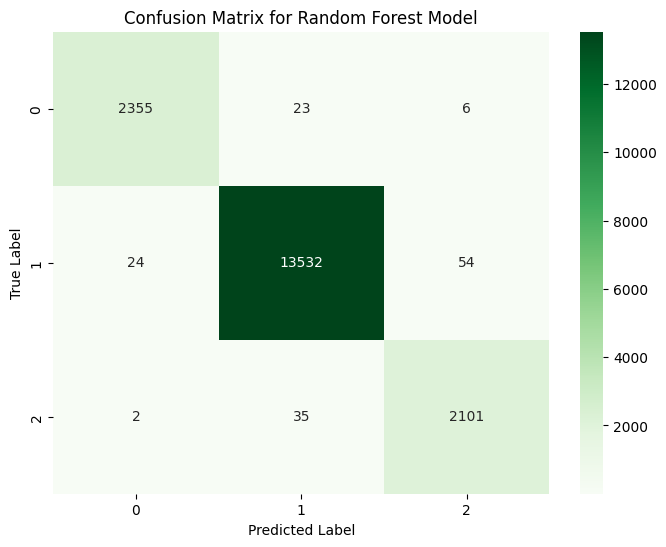

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_rf = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nAccuracy of Random Forest Model: {accuracy_rf:.4f}")

class_report_rf = classification_report(y_test, y_pred_rf)
print("\nClassification Report for Random Forest Model:\n", class_report_rf)

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix for Random Forest Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Importación Global Hato




El dataset de Global Hato contiene informacion global sobre el estado de los animales dentro del CAETEC (vacas, becerros, machos, novillas). Dentro del dataset hay información sobre la producción de leche y el estado reproductivo de la vaca.

In [ ]:
global_hato_path = '/content/drive/MyDrive/Vacas/global_hato_df.csv'

global_hato_df = pd.read_csv(global_hato_path)

In [ ]:
display(global_hato_df)

,Número del animal,Estado de la reproducción,Nº Lactación,Días en ordeño,Número de inseminaciones,Días preñada,Días para el parto,Producción de leche ayer,Producción media diaria últimos 7 días,Producción TOTAL en lactación
0,5704,Inseminada,7.0,97.0,1.0,0.0,0.0,33.01,31.10,2675.94
1,5921,Abierta,6.0,65.0,0.0,0.0,0.0,33.70,37.79,2606.48
2,6003,Inseminada,5.0,219.0,3.0,0.0,0.0,26.29,25.94,8002.61
3,6036,Abierta,6.0,50.0,0.0,0.0,0.0,55.45,52.44,2530.28
4,5981,Inseminada,5.0,111.0,1.0,0.0,0.0,47.71,44.75,4450.66
...,...,...,...,...,...,...,...,...,...,...
158,1577,Preñada,3.0,374.0,4.0,194.0,89.0,29.73,27.35,16764.70
159,2107,Preñada,2.0,311.0,2.0,209.0,74.0,18.04,18.75,10927.03
160,2150,Preñada,2.0,306.0,1.0,228.0,55.0,25.38,25.94,11933.75
161,8715,Preñada,1.0,292.0,1.0,228.0,55.0,23.64,23.55,10061.69


In [ ]:
X_global_hato = global_hato_df.drop([
                      'Número del animal',
                      'Estado de la reproducción',], axis=1).copy()

In [ ]:
y_pred_rf = rf_model.predict(X_global_hato)

label_map = {
    1: 'En Producción',
    0: 'En Monitoreo',
    2: 'Previo a Secado'
}

predicted_labels = pd.DataFrame({'Estado de Producción': y_pred_rf})
predicted_labels['Estado de Producción'] = predicted_labels['Estado de Producción'].map(label_map)

global_hato_df['Estado de Producción'] = predicted_labels['Estado de Producción']

display(global_hato_df)

,Número del animal,Estado de la reproducción,Nº Lactación,Días en ordeño,Número de inseminaciones,Días preñada,Días para el parto,Producción de leche ayer,Producción media diaria últimos 7 días,Producción TOTAL en lactación,Estado de Producción
0,5704,Inseminada,7.0,97.0,1.0,0.0,0.0,33.01,31.10,2675.94,En Producción
1,5921,Abierta,6.0,65.0,0.0,0.0,0.0,33.70,37.79,2606.48,En Producción
2,6003,Inseminada,5.0,219.0,3.0,0.0,0.0,26.29,25.94,8002.61,En Producción
3,6036,Abierta,6.0,50.0,0.0,0.0,0.0,55.45,52.44,2530.28,En Producción
4,5981,Inseminada,5.0,111.0,1.0,0.0,0.0,47.71,44.75,4450.66,En Producción
...,...,...,...,...,...,...,...,...,...,...,...
158,1577,Preñada,3.0,374.0,4.0,194.0,89.0,29.73,27.35,16764.70,En Producción
159,2107,Preñada,2.0,311.0,2.0,209.0,74.0,18.04,18.75,10927.03,En Producción
160,2150,Preñada,2.0,306.0,1.0,228.0,55.0,25.38,25.94,11933.75,En Producción
161,8715,Preñada,1.0,292.0,1.0,228.0,55.0,23.64,23.55,10061.69,Previo a Secado
